In [1]:
# Be sure that you are using the yield-engine environement
import sys
print(sys.executable)

# Setup

In [2]:
PATH_YIELD_ENGINE = 'src'

def set_paths() -> None:
    """
    set correct working directory and python path when started from within PyCharm
    """
    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir)
        os.chdir(cwd)
    
    print(f"working dir is '{os.getcwd()}'")
                             
    if PATH_YIELD_ENGINE not in sys.path:
        sys.path.insert(0, PATH_YIELD_ENGINE)
    
    print(f"added `{sys.path[0]}` to python paths")

set_paths()

In [3]:
import logging
import os    
import re
import pprint
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from typing import *

from yieldengine import Sample
from yieldengine.dendrogram import DendrogramDrawer
from yieldengine.dendrogram.style import FeatMapStyle, LineStyle
from yieldengine.df.pipeline import PipelineDF
from yieldengine.preprocessing.encode import OneHotEncoderDF
from yieldengine.preprocessing.impute import SimpleImputerDF, MissingIndicatorDF
from yieldengine.preprocessing.selection import BorutaDF
from yieldengine.preprocessing.compose import ColumnTransformerDF
from yieldengine.model.inspection import ModelInspector
from yieldengine.model.prediction import PredictorCV
from yieldengine.model.selection import ModelPipelineDF, ModelGrid, ModelRanker, summary_report, ModelEvaluation, ModelScoring
from yieldengine.model.validation import CircularCrossValidator
from yieldengine.visualization.eda import plot_ecdf, plot_ecdf_df, plot_hist_df
from yieldengine.preprocessing.outlier import TukeyOutlierRemoverDF
from yieldengine.preprocessing import FunctionTransformerDF
from yieldengine.simulation import UnivariateSimulation

C:\Users\martin florent\AppData\Local\Continuum\anaconda3\envs\yield-engine\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
log = logging.getLogger(__name__)

# Utilities

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

# Load data

## Raw data

In [6]:
DATA_DIR = os.path.join('data', 'ames-housing-dataset')
RAW_DATA_CSV = os.path.join(DATA_DIR, 'train.csv')
TARGET = "SalePrice"

In [7]:
print(f"Read {RAW_DATA_CSV}")
raw_df = pd.read_csv(RAW_DATA_CSV)

Read data\ames-housing-dataset\train.csv


## EDA

In [8]:
print(f"Shape of the raw data: {raw_df.shape}")

Shape of the raw data: (1460, 81)


In [9]:
raw_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
raw_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [11]:
dt = raw_df.dtypes.rename('dtype').astype(str)
dt.groupby(by=dt.values).count().to_frame()

,dtype
float64,3
int64,35
object,43


## Description of the variables

In [12]:
DESCRIPTION = os.path.join(DATA_DIR, 'data_description.txt')
with open(DESCRIPTION, 'r') as f:
    description = f.read()
print(description[:1000])

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [13]:
# Create a dictionary containing description of the variables
splitted = description.split()
idx_begin = [i for i, w in enumerate(description.split()) if w.endswith(':')]
description_dict = {
       splitted[idx_begin[i]][:-1]: ' '.join(splitted[idx_begin[i]+1: idx_begin[i+1]]) for i in range(len(idx_begin)-1)
}

In [14]:
pprint.pprint(description_dict)

{'1stFlrSF': 'First Floor square feet',
 '2ndFlrSF': 'Second floor square feet',
 '3SsnPorch': 'Three season porch area in square feet',
 'Alley': 'Type of alley access to property Grvl Gravel Pave Paved NA No alley '
          'access',
 'Bedroom': 'Bedrooms above grade (does NOT include basement bedrooms)',
 'BldgType': 'Type of dwelling 1Fam Single-family Detached 2FmCon Two-family '
             'Conversion; originally built as one-family dwelling Duplx Duplex '
             'TwnhsE Townhouse End Unit TwnhsI Townhouse Inside Unit',
 'BsmtCond': 'Evaluates the general condition of the basement Ex Excellent Gd '
             'Good TA Typical - slight dampness allowed Fa Fair - dampness or '
             'some cracking or settling Po Poor - Severe cracking, settling, '
             'or wetness NA No Basement',
 'BsmtExposure': 'Refers to walkout or garden level walls Gd Good Exposure Av '
                 'Average Exposure (split levels or foyers typically score '
                 'av

 'LowQualFinSF': 'Low quality finished square feet (all floors)',
 'MSSubClass': 'Identifies the type of dwelling involved in the sale. 20 '
               '1-STORY 1946 & NEWER ALL STYLES 30 1-STORY 1945 & OLDER 40 '
               '1-STORY W/FINISHED ATTIC ALL AGES 45 1-1/2 STORY - UNFINISHED '
               'ALL AGES 50 1-1/2 STORY FINISHED ALL AGES 60 2-STORY 1946 & '
               'NEWER 70 2-STORY 1945 & OLDER 75 2-1/2 STORY ALL AGES 80 SPLIT '
               'OR MULTI-LEVEL 85 SPLIT FOYER 90 DUPLEX - ALL STYLES AND AGES '
               '120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER 150 '
               '1-1/2 STORY PUD - ALL AGES 160 2-STORY PUD - 1946 & NEWER 180 '
               'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER 190 2 FAMILY '
               'CONVERSION - ALL STYLES AND AGES',
 'MSZoning': 'Identifies the general zoning classification of the sale. A '
             'Agriculture C Commercial FV Floating Village Residential I '
             'Industrial RH Re

## Sort by sold date
We sort the samples by selling date

In [15]:
description_dict['YrSold']

'Year Sold (YYYY)'

In [16]:
description_dict['MoSold']

'Month Sold (MM)'

In [17]:
df_tmp = raw_df.copy()

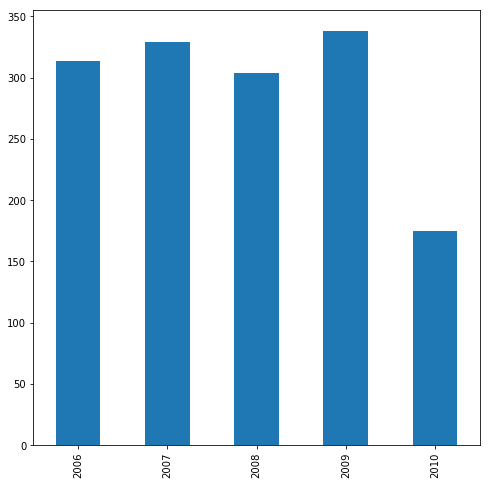

In [18]:
df_tmp['YrSold'].value_counts().sort_index().plot(kind='bar')

In [19]:
df_tmp['DateSold'] = pd.to_datetime(df_tmp['YrSold']*100 + df_tmp['MoSold'], format='%Y%m')

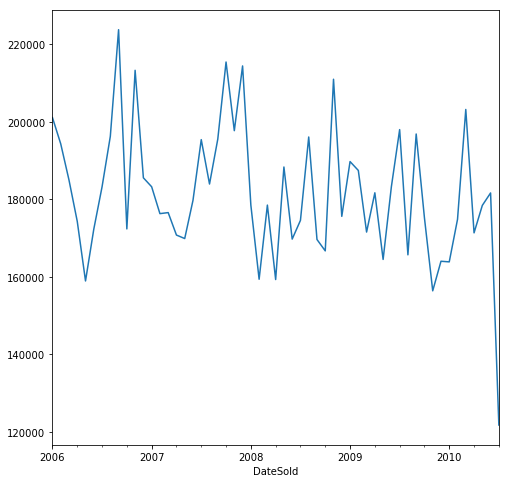

In [20]:
df_tmp.groupby('DateSold')[TARGET].mean().plot()

## Data Prep

In [21]:
dataset_df = raw_df.copy()

In [22]:
# Remove data columns
dataset_df = dataset_df.sort_values(by=['YrSold', 'MoSold'])

In [23]:
# Drop the Id column and date columns
dataset_df = dataset_df.drop(['Id', 'YrSold', 'MoSold'], axis=1)

In [24]:
features_df = dataset_df.drop(columns=TARGET)

cat_features = features_df.select_dtypes(['category', object]).columns
num_features = features_df.select_dtypes('number').columns

print (f"{features_df.shape[1] - len(cat_features) - len(num_features)} not a number or category")

del features_df

0 not a number or category


In [25]:
# remove infinity values
dataset_df = dataset_df.replace([np.inf, -np.inf], np.nan)

In [26]:
for col_name in cat_features:
    dataset_df.loc[:, col_name] = (
        dataset_df.loc[:, col_name].astype(object).fillna('missing value').astype(str).str.strip().str.lower().astype('category')
    )

# output datasets

dt = dataset_df.dtypes.rename('dtype').astype(str)
dt.groupby(by=dt.values).count().to_frame()

,dtype
category,43
float64,3
int64,32


## Select only numerical features
For simplicity we select only numerical features

In [27]:
dataset_df = dataset_df[list(num_features) + [TARGET]]

# remove outliers for the target

## Remove outliers

In [28]:
outlier_remover = TukeyOutlierRemoverDF(iqr_threshold=1.5)

In [29]:
# Filter out the rows of the dataset where the target is  NaN
print(f"Shape before removal of target outlier: {dataset_df.shape}")
mask = outlier_remover.fit_transform(dataset_df[[TARGET]])[TARGET].notna()
dataset_df = dataset_df.loc[mask, :]
print(f"Shape after removal outlier: {dataset_df.shape}")

Shape before removal of target outlier: (1460, 35)
Shape after removal outlier: (1399, 35)


## Create Sample object to be used by our model

In [30]:
# Define a Sample object to be used by our model
sample_full = Sample(
    observations=dataset_df,
    target_name=TARGET)

In [31]:
# Print statistics of the target
print(
    f"{TARGET}: µ={sample_full.target.mean():.3g}, "
    f"σ={sample_full.target.std():.3g}={100 * sample_full.target.std() / sample_full.target.mean():.3g}%")

SalePrice: µ=1.7e+05, σ=5.92e+04=34.8%


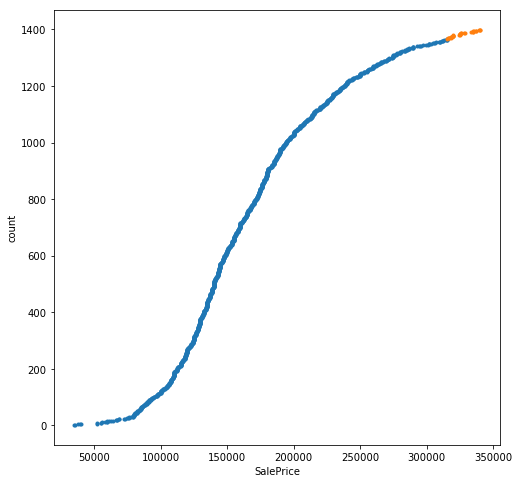

In [32]:
plot_ecdf(sample_full.target)

## imputation and encoding

In [33]:
def make_preprocessor(sample: Sample, onehot: bool = True, missing: bool = True):

    tx = []
    
    # define how features should be preprocessed
    tx.append((
        "impute", 
        SimpleImputerDF(strategy="median"), 
        sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
    ))

    if missing:
        tx.append((
            "missing", 
            MissingIndicatorDF(error_on_new=False), 
            sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
        ))
        
    if onehot:
        tx.append((
            "onehot", 
            OneHotEncoderDF(sparse=False, handle_unknown="ignore"),
            sample.features_by_type([Sample.DTYPE_CATEGORICAL]).columns,
        )) 
    

    return ColumnTransformerDF(
        transformers=tx
    )

## Feature selection (Boruta)

In [34]:
outlier_transformers = [
    ('outlier', TukeyOutlierRemoverDF(iqr_threshold=2), sample_full.features_by_type(Sample.DTYPE_NUMERICAL).columns),
    ('rest', FunctionTransformerDF(validate=False), sample_full.features_by_type(Sample.DTYPE_OBJECT).columns)
]
outlier_step = ColumnTransformerDF(transformers=outlier_transformers)

In [35]:
preprocessor = make_preprocessor(sample=sample_full, missing=True, onehot=True)

In [36]:
boruta_selector = PipelineDF(
    steps = [
        ('outlier_removal', outlier_step),
        ('preprocess', preprocessor),
        ('boruta', BorutaDF(estimator=RandomForestRegressor(max_depth=5,min_samples_leaf=8,
                                                            random_state=42,n_jobs=-3),
                             n_estimators='auto', verbose=2, max_iter=100, random_state=42))
    ]
)

In [37]:
# with np.errstate(invalid='ignore'):
#     boruta_selector.fit(sample_full.features, sample_full.target)

In [38]:
boruta_selector.fit(sample_full.features, sample_full.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	6
Reject

In [39]:
selected = sorted(list(set(boruta_selector.columns_original)))
print(list(selected))
if selected is None:
    raise NotImplementedError("You need to specify a backup set of variables")

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces', 'GarageArea', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MSSubClass', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


In [40]:
boruta_selector['boruta']

BorutaDF(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=5, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=8,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=126, n_jobs=-3,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000001C8B7273AF8>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=<mtrand.RandomState object at 0x000001C8B7273AF8>,
         

In [41]:
sample = sample_full.select_features(selected)

## Data Visualization of numerical features and categorical features

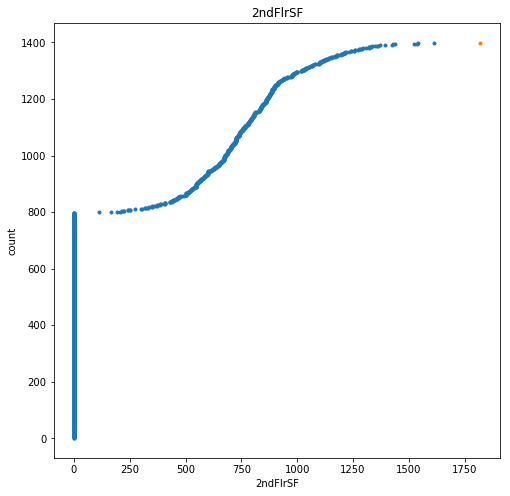

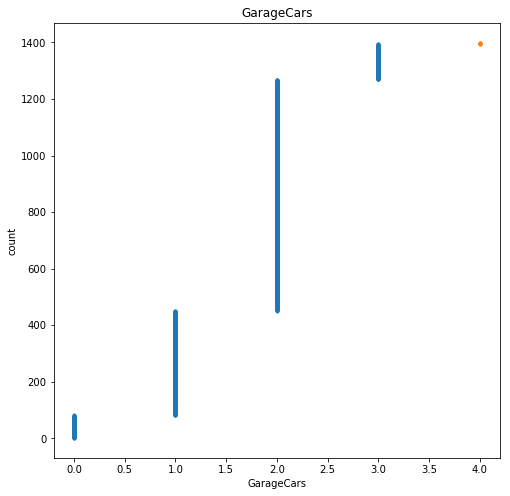

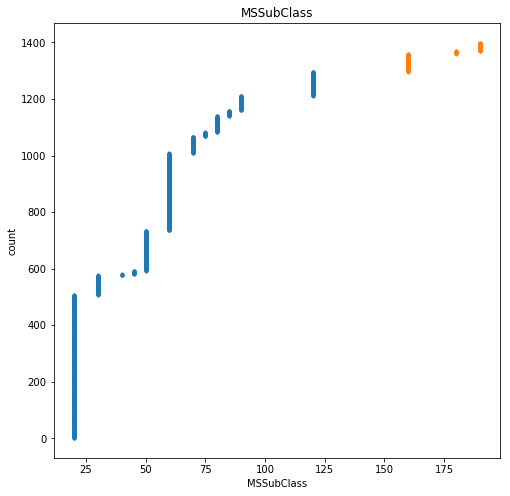

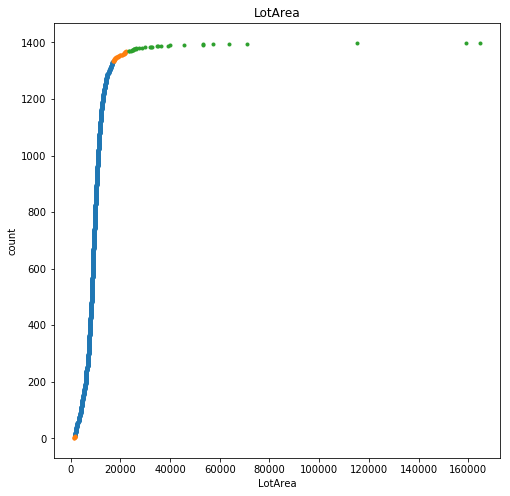

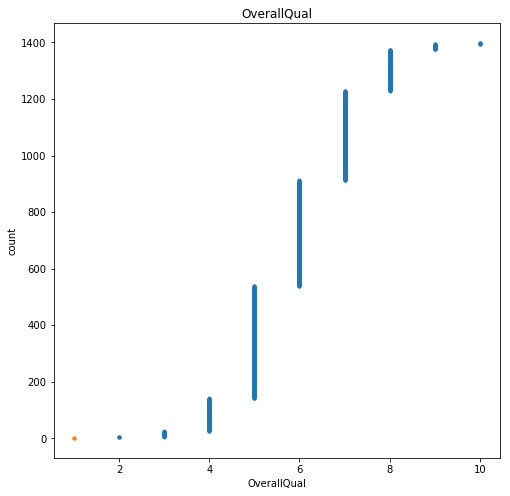

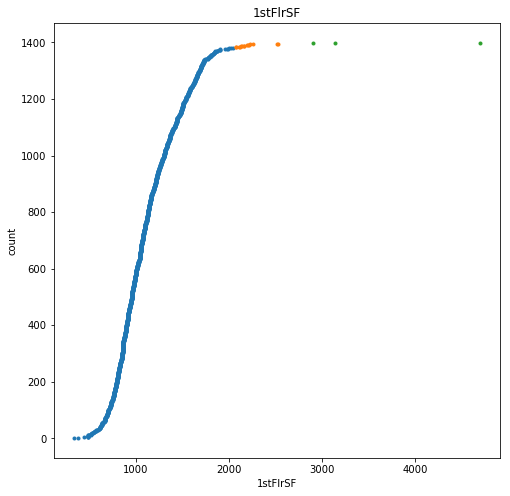

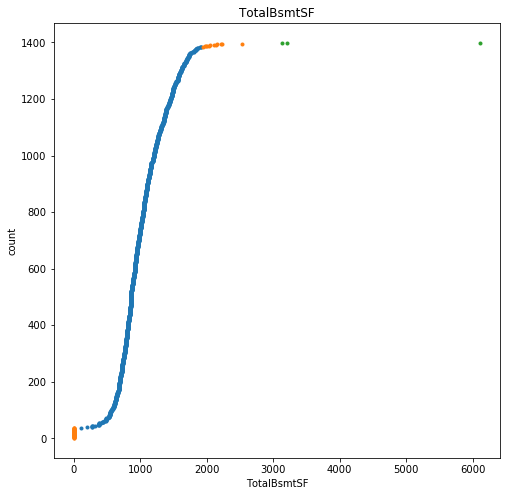

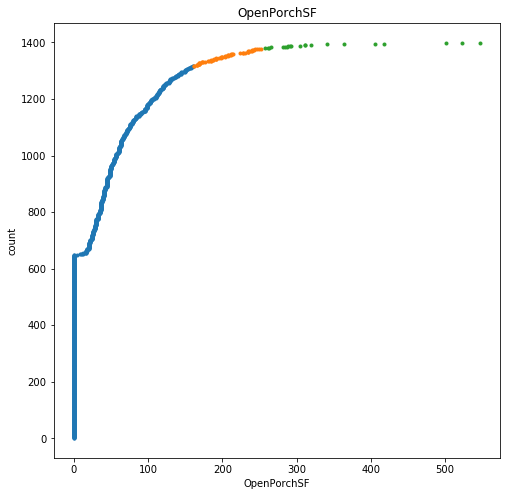

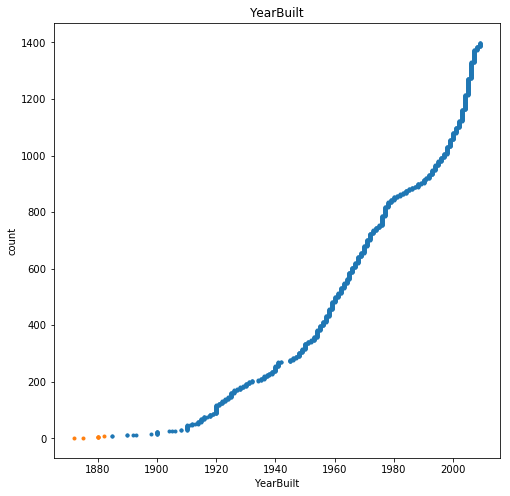

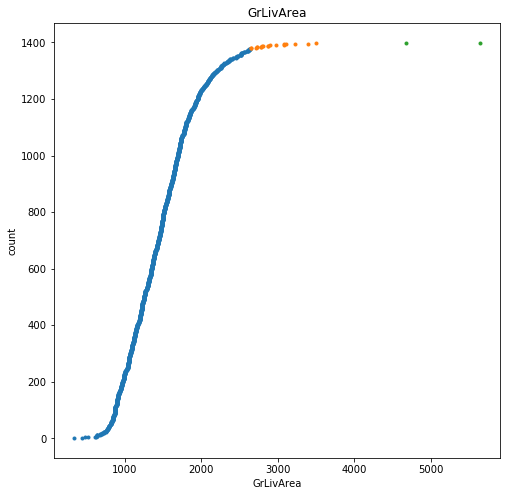

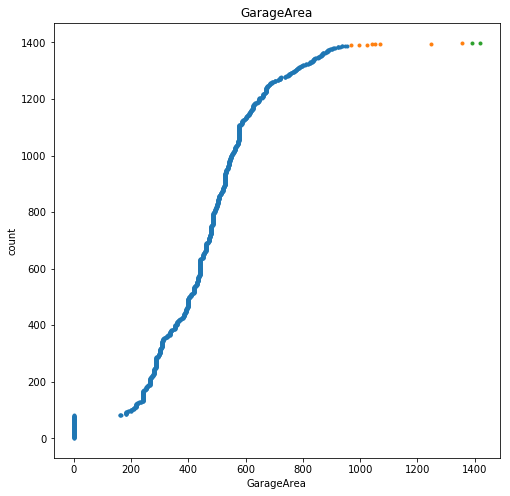

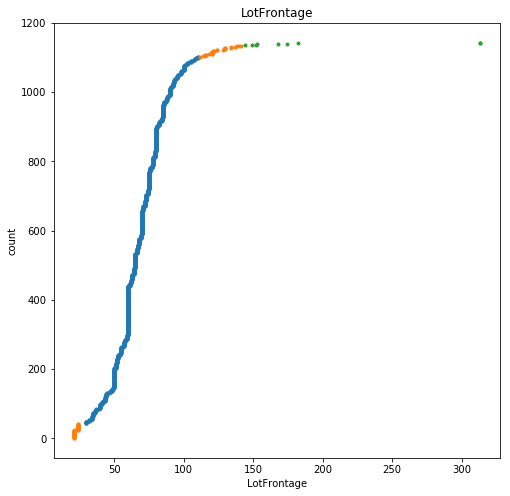

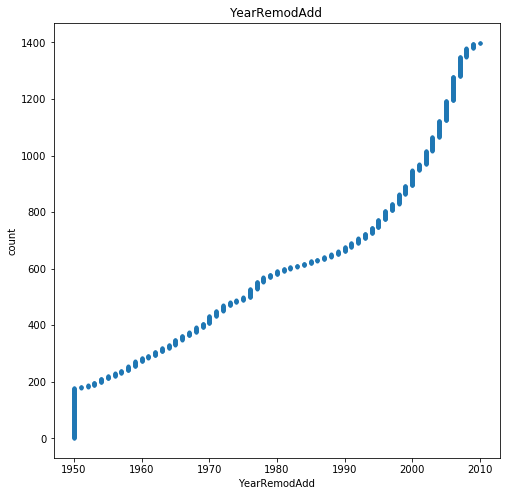

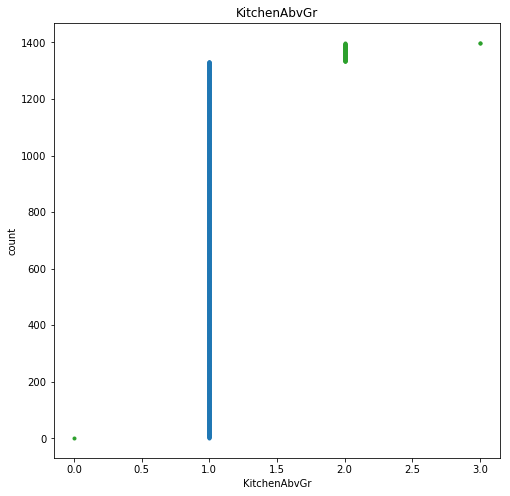

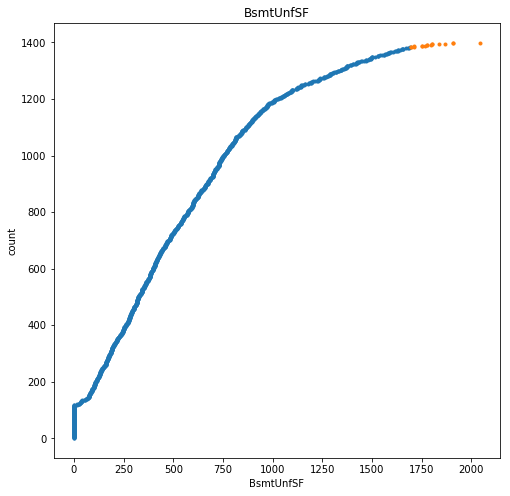

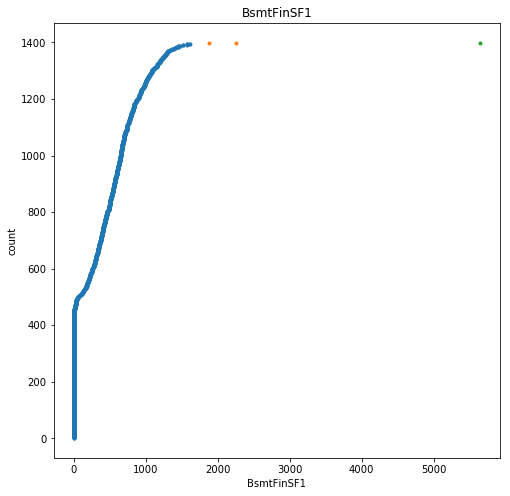

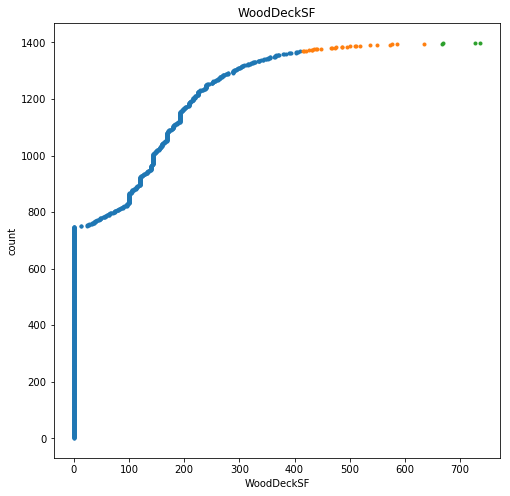

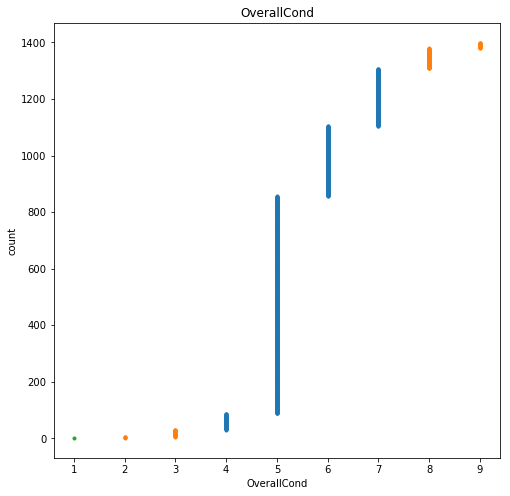

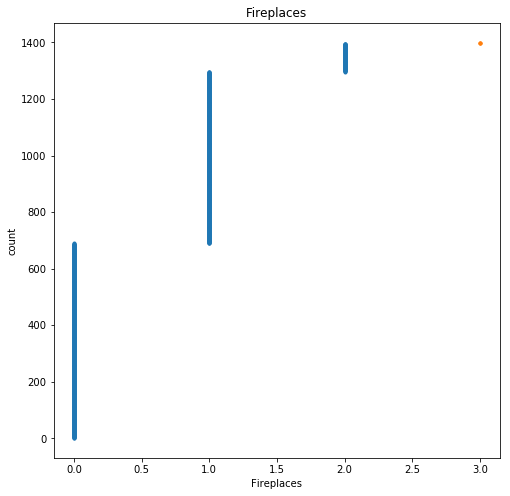

In [42]:
plot_ecdf_df(sample.features)

In [43]:
plot_hist_df(sample.features)

# ModelPipelineDF training

## Define cross validator

In [44]:
# define the circular cross validator with 30 folds
circular_cv = CircularCrossValidator(test_ratio=1/3, num_splits=3)

## Grid search

In [45]:
grids = [
    ModelGrid(
        model=ModelPipelineDF(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [1000],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
print(f"{len(grids)} model grid(s)")

1 model grid(s)


In [46]:
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
)
ranker

In [47]:
ranking = ranker.run(sample, n_jobs=-3)

In [48]:
print(summary_report(ranking))

Rank  1: RandomForestRegressor, Score=     0.83, test_score_mean=    0.845, test_score_std=  0.00712, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  2: RandomForestRegressor, Score=     0.83, test_score_mean=    0.846, test_score_std=  0.00777, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  3: RandomForestRegressor, Score=    0.829, test_score_mean=    0.837, test_score_std=  0.00386, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=1.0,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  4: RandomForestRegressor, Score=    0.818, test_score_mean=    0.832, test_score_std=  0.00671, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estima

In [49]:
top_model = ranking[0]
top_model.scoring['test_score']

In [50]:
top_model.parameters

{'estimator__criterion': 'mse',
 'estimator__max_depth': 6,
 'estimator__max_features': 0.7,
 'estimator__min_samples_leaf': 4,
 'estimator__n_estimators': 1000}

median score: 0.84; mean score: 0.84


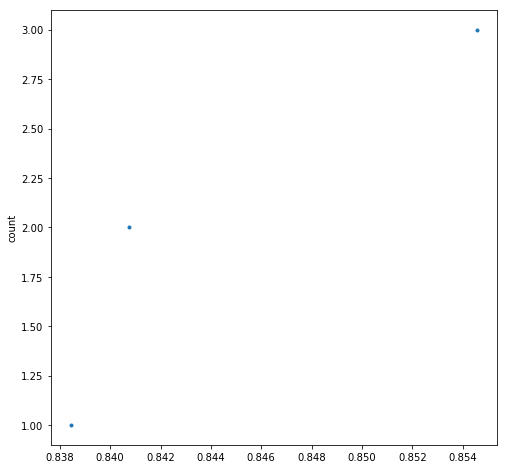

In [51]:
top_model_scores = top_model.scoring['test_score'].split_scores
plot_ecdf(pd.Series(top_model_scores))
print(f"median score: {np.median(top_model_scores):.2g}; mean score: {np.mean(top_model_scores):.2g}")

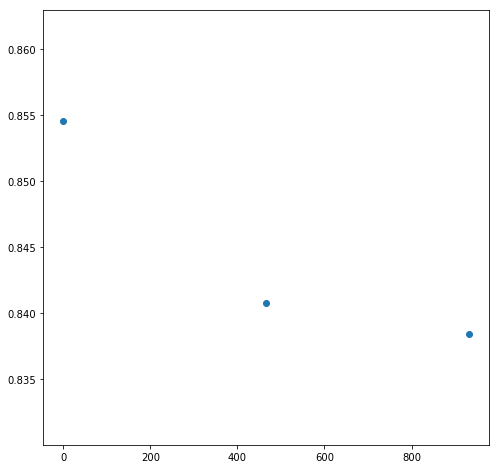

In [52]:
# plot test folds against test scores
plt.scatter(x=list(circular_cv.test_split_starts(sample.features)), y=top_model_scores)

In [53]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample)

In [54]:
inspector = ModelInspector(predictor)

In [55]:
predictions = predictor.predictions_for_all_samples()

Text(0, 0.5, 'predicted')

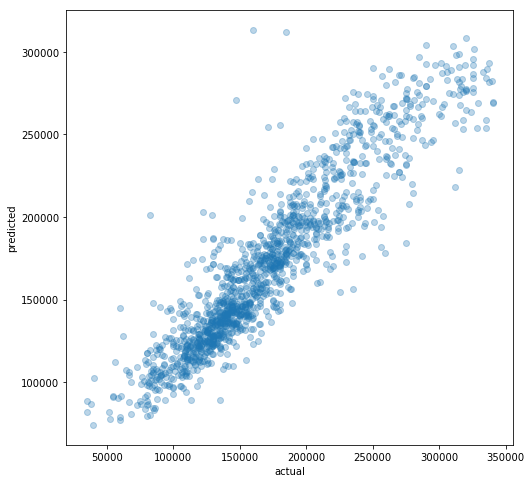

In [56]:
plt.scatter(
    sample.target.sort_index(),
    predictions.groupby(predictions.index)['prediction'].mean().sort_index(),
    alpha=.3
)
plt.xlabel('actual')
plt.ylabel('predicted')

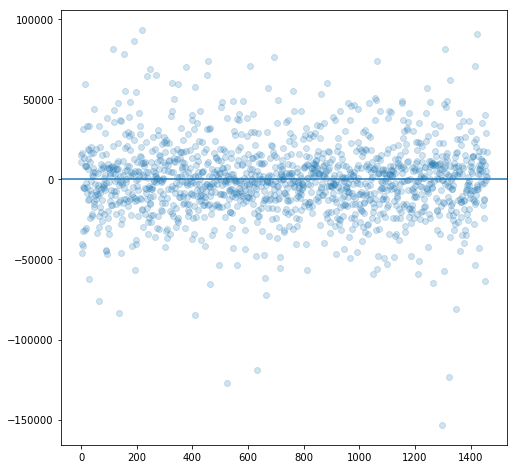

In [57]:
predictions['error'] = (predictions['target'] - predictions['prediction'])#.abs()
plt.scatter(x=predictions.index.values, y=predictions['error'].values, alpha=.2)
plt.axhline(0)

In [58]:
mae_model = mean_absolute_error(y_pred=predictions.prediction, y_true=predictions.target)
mae_naive = mean_absolute_error(y_pred=[predictions.target.mean()]* len(predictions), y_true=predictions.target)

print(f"MAE_relative={mae_model / mae_naive * 100:1000.3g}%, MAE_model={mae_model:.3g}, MAE_naïve={mae_naive:.3g}")

MAE_relative=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [59]:
M = inspector.shap_matrix()

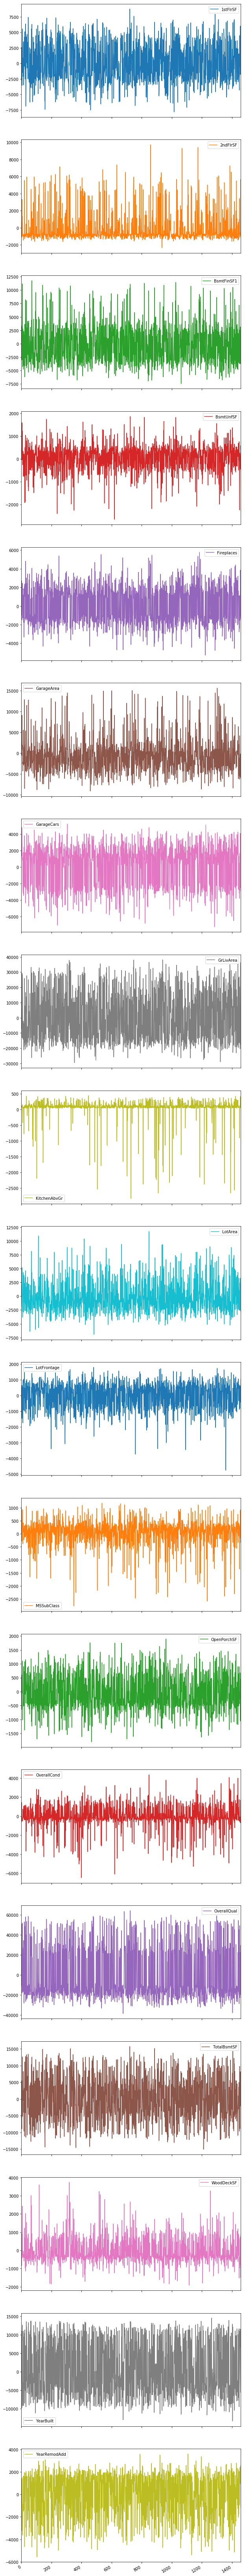

In [60]:
number_features = predictor.sample.features.shape[1]
_ = M.plot(subplots=True, figsize=(10, number_features*7))

In [61]:
inspector.shap_matrix().head().T

,0,1,2,3,4
column,,,,,
1stFlrSF,-2679.706317,2577.711789,-2237.817186,-2677.888018,505.879242
2ndFlrSF,522.761817,-1098.495715,660.225734,-484.842119,3337.133043
BsmtFinSF1,566.304170,3255.921409,-929.799483,-3035.463543,-93.666358
BsmtUnfSF,421.048162,315.612754,419.180228,-43.220986,1592.655932
Fireplaces,-979.501448,2708.361191,826.982174,2200.679845,1237.029149
GarageArea,178.315173,-553.824759,2594.869963,1478.544001,9114.617122
GarageCars,1363.319337,2143.413363,1331.193918,4796.920345,3000.443965
GrLivArea,5283.188037,-7233.404563,8827.824308,8253.710446,29324.661440
KitchenAbvGr,65.589941,107.717309,66.079758,113.056867,61.725475


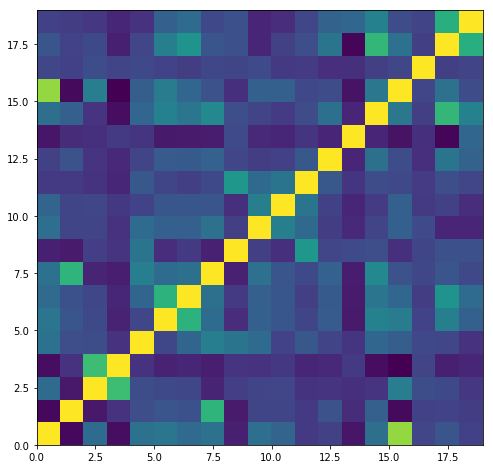

In [62]:
depm = inspector.feature_dependency_matrix()
plt.pcolormesh(depm)

In [63]:
inspector.feature_importances().sort_values(ascending=False).to_frame()

,0
column,
OverallQual,0.328148
GrLivArea,0.202013
YearBuilt,0.091256
TotalBsmtSF,0.078136
GarageArea,0.042483
BsmtFinSF1,0.040999
1stFlrSF,0.037829
GarageCars,0.031746
LotArea,0.030258


In [64]:
linkage_tree = inspector.cluster_dependent_features()

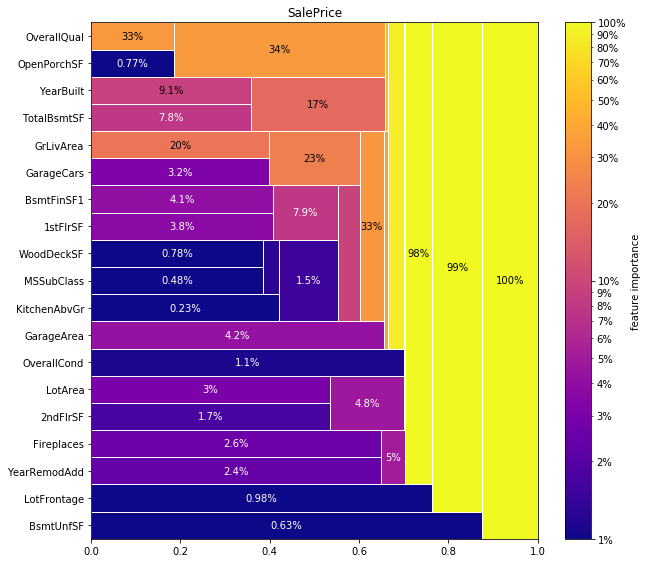

In [65]:
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

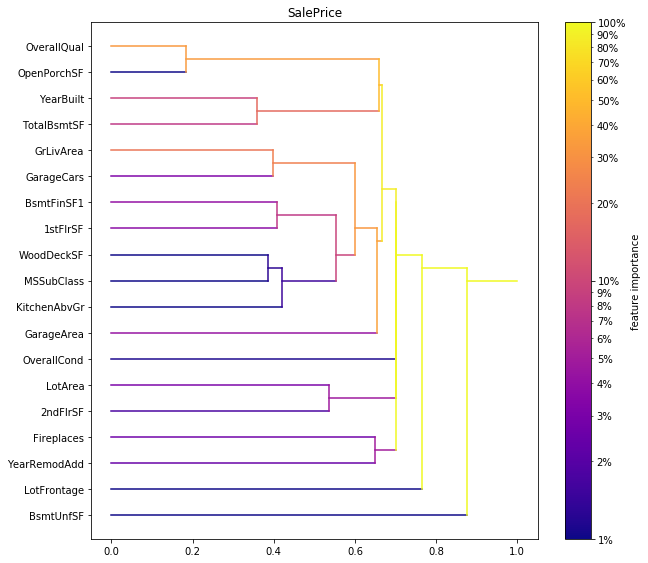

In [66]:
ax = plt.figure(figsize=(10,number_features*0.5)).add_subplot(111)
style = LineStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

# Shap clustering iteration 1

In [67]:
features1 = sample.feature_names

In [68]:
black_list1 = ['WoodDeckSF', 
               #'BsmtFinSF1', 
               'BsmtUnfSF', 
               'MasVnrArea',
               'LotFrontage']

In [69]:
if not set(black_list1) <= features1:
    log.warning(f"""The black list must be a subset of the set of features: the features 
    {set(black_list1)-set(features1)} are in black list but not in the features.""")

    {'MasVnrArea'} are in black list but not in the features.


In [70]:
white_list1 = sorted(list(set(features1) - set(black_list1)))
print(f"New white list:\n {white_list1}")

New white list:
 ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'Fireplaces', 'GarageArea', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MSSubClass', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


In [71]:
sample1 = sample.select_features(white_list1)

## Re-run the pipeline

In [72]:
preprocessor = make_preprocessor(sample=sample1, missing=True, onehot=True)
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample1.features, sample1.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	0


In [73]:
selected1 = sorted(list(set(boruta_selector.columns_original)))
print(list(selected1))
sample1 = sample1.select_features(selected1)

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'Fireplaces', 'GarageArea', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MSSubClass', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


In [74]:
grids = [
    ModelGrid(
        model=ModelPipelineDF(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample1, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [1000],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
)
ranking = ranker.run(sample1, n_jobs=-3)

In [75]:
print(summary_report(ranking))

Rank  1: RandomForestRegressor, Score=    0.833, test_score_mean=    0.844, test_score_std=   0.0058, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  2: RandomForestRegressor, Score=    0.832, test_score_mean=    0.846, test_score_std=  0.00679, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  3: RandomForestRegressor, Score=    0.831, test_score_mean=    0.837, test_score_std=  0.00321, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=1.0,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  4: RandomForestRegressor, Score=     0.82, test_score_mean=    0.834, test_score_std=  0.00659, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estima

In [76]:
top_model = ranking[0]
print(f"top_model score: {top_model.scoring['test_score']}")

top_model score: <yieldengine.model.selection.ModelScoring object at 0x000001C8B9B8ABA8>


In [77]:
print(top_model.parameters)

{'estimator__criterion': 'mse', 'estimator__max_depth': 6, 'estimator__max_features': 0.7, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 1000}


In [78]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample1)
inspector = ModelInspector(predictor)
M = inspector.shap_matrix()

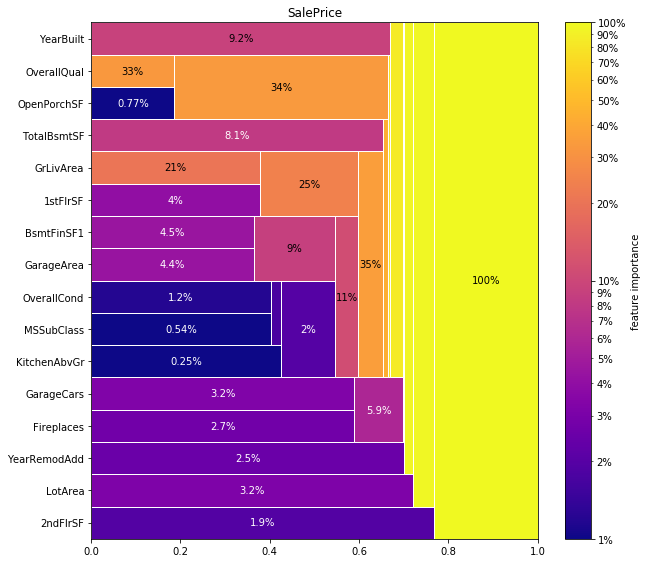

In [79]:
linkage_tree = inspector.cluster_dependent_features()
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

In [80]:
description_dict['OverallCond']

'Rates the overall condition of the house 10 Very Excellent 9 Excellent 8 Very Good 7 Good 6 Above Average 5 Average 4 Below Average 3 Fair 2 Poor 1 Very Poor'

# Shap clustering iteration 2

In [81]:
features2 = sample1.feature_names

In [82]:
black_list2 = [
    "OverallCond"
]

In [83]:
if not set(black_list2) <= features2:
    log.warning(f"""The black list must be a subset of the set of features: the features 
    {set(black_list2)-set(features2)} are in black list but not in the features.""")

In [84]:
assert set(black_list2) <= features2, "The black list must be a subset of the set of features"

In [85]:
white_list2 = sorted(list(set(features2) - set(black_list2)))
print(f"New white list:\n {white_list2}")

New white list:
 ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'Fireplaces', 'GarageArea', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MSSubClass', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


In [86]:
sample2 = sample1.select_features(white_list2)

## Re-run the pipeline

In [87]:
preprocessor = make_preprocessor(sample=sample2, missing=True, onehot=True)
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample2.features, sample2.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	0


In [88]:
selected2 = sorted(list(set(boruta_selector.columns_original)))
print(list(selected2))
sample2 = sample2.select_features(selected2)

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'Fireplaces', 'GarageArea', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'MSSubClass', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


In [89]:
grids = [
    ModelGrid(
        model=ModelPipelineDF(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample2, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [1000],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
    #scoring='neg_mean_absolute_error'
)
ranking = ranker.run(sample2, n_jobs=-3)

In [90]:
print(summary_report(ranking))

Rank  1: RandomForestRegressor, Score=    0.829, test_score_mean=    0.842, test_score_std=  0.00674, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  2: RandomForestRegressor, Score=    0.829, test_score_mean=    0.841, test_score_std=  0.00603, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  3: RandomForestRegressor, Score=    0.827, test_score_mean=    0.834, test_score_std=  0.00326, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=1.0,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  4: RandomForestRegressor, Score=    0.817, test_score_mean=    0.831, test_score_std=  0.00667, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estima

In [91]:
top_model = ranking[0]
print(f"top_model score: {top_model.scoring['test_score']}")

top_model score: <yieldengine.model.selection.ModelScoring object at 0x000001C8B9BB5D68>


In [92]:
print(top_model.parameters)

{'estimator__criterion': 'mse', 'estimator__max_depth': 6, 'estimator__max_features': 0.4, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 1000}


In [93]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample2)
inspector = ModelInspector(predictor)
M = inspector.shap_matrix()

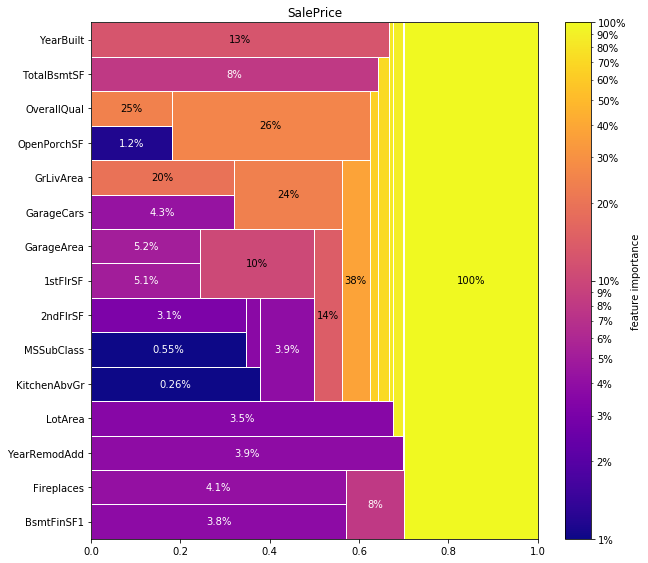

In [94]:
linkage_tree = inspector.cluster_dependent_features()
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

# Simulation

In [95]:
sim = UnivariateSimulation(predictor=predictor)

In [96]:
from IPython.display import display, clear_output
import ipywidgets as widgets



dd = widgets.Dropdown(
    options=predictor.sample.features.columns,
    description='Feature:',
    disabled=False,
    layout={"width":"550px"}
)

btn = widgets.Button(
    description='Simulate'
)

def plot_simulation(feature:str):
    yield_change = sim.simulate_yield_change(
            parameterized_feature=feature,
            parameter_values=UnivariateSimulation.observed_feature_values(
                feature_name=feature,
                sample=predictor.sample,
                min_relative_frequency=0.03,
                limit_observations=100
            ),
    )
    
    yield_change_aggr = UnivariateSimulation.aggregate_simulated_yield_change(
                    results_per_split=yield_change, percentiles=[10, 50, 90])
    
    XLABEL_TITLE = f"{feature}"
    YLABEL_TITLE = f"Predicted mean yield uplift ({TARGET})"
    COLOR1 = 'red'
    COLOR2 = 'silver'
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
    
    # plot lines of prediction
    ax1.set_xlabel(XLABEL_TITLE, color='black', labelpad=10, fontsize=12)
    ax1.set_ylabel(YLABEL_TITLE, color='black', fontsize=12)
    line1, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,0], color=COLOR2, linewidth=1)
    line2, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,1], color=COLOR1)
    line3, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,2], color=COLOR2, linewidth=1)
    ax1.axhline(y=0, color='black', linewidth=.5)
    ax1.tick_params(axis='x', labelcolor='black')
    for pos in ['top', 'right', 'bottom']:
        ax1.spines[pos].set_visible(False)
    ax1.tick_params(axis='x', labelbottom=True, bottom=False)
    ax1.legend((line3, line2, line1), 
               ('90th percentile', 'Median', '10th percentile'), 
               frameon=False,
              )
    
    # plot the histogram
    x = sample.features[feature].dropna()
    hist_range = (min(yield_change_aggr.index), max(yield_change_aggr.index))
    n, bins, patches = ax2.hist(x, edgecolor='white', color=COLOR2, range=hist_range)
    bins1 = pd.Series(bins).rolling(window=2).mean().shift(-1).dropna()
    ax2.invert_yaxis()
    ax2.tick_params(axis='y', labelcolor='black')
    max_y = max(n)
    y_offset = max_y * 0.05
    for (x,y) in zip(bins1, n):
        if y>0:
            ax2.text(x, y + y_offset, str(int(y)), 
                    color='black', 
                    horizontalalignment='center')
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    for pos in ['top', 'right', 'left', 'bottom']:
        ax2.spines[pos].set_visible(False)
    plt.subplots_adjust(hspace=.2)
    plt.show()

def on_click(btn):
    clear_output()
    display(widgets.HBox([dd, btn]))
    plot_simulation(feature=dd.value)
    
btn.on_click(on_click)    
display(widgets.HBox([dd, btn]))